## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !apt install pyvirtualdisplay
    !pip install -U gym
    from pyvirtualdisplay import Display
    
    # Start vitual display
    dis = Display(visible = 0, size = (400,400))
    dis.start()
    
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py

## Rainbow

In [2]:
import gym
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from IPython.display import clear_output
from segment_tree import MinSegmentTree, SumSegmentTree
from torch.nn.utils import clip_grad_norm_
from typing import Dict, List, Tuple

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer"""
    
    def __init__(self,obs_dim: int,size: int,batch_size: int = 32,n_step: int = 1,gamma: float = 0.99):
        self.obs_buf = np.zeros([size, obs_dim], dtype = np.float32) # 观测的当前状态的大小 X 每一个观测状态reshape后的维度
        self.next_obs_buf = np.zeros([size, obs_dim], dtype = np.float32) # 观测的下一状态的大小 X 每一个观测的下一个状态reshape后的维度
        self.acts_buf = np.zeros([size], dtype = np.float32) # 记录状态变迁过程中具体执行了哪个动作
        self.rews_buf = np.zeros([size], dtype = np.float32) # 记录状态变迁过程中具体执行了那个动作后得到的奖励
        self.done_buf = np.zeros([size], dtype = np.float32) # 记录状态变迁后新的状态是否结束
        self.max_size = size # 指定ReplayBuffer的大小
        self.batch_size = batch_size # 指定一次训练中的样本数量
        self.ptr = 0 # 制定当前的batch数据起始位置在全部数据池中的位置
        self.size = 0 # 暂时记录当前数据量的大小
        self.n_step_buffer = deque(maxlen = n_step) # 存储最近N步的经验
        self.n_step = n_step # 定义N-step learning中的N
        self.gamma = gamma # 定义递减折扣因子
    
    def store(self,obs: np.ndarray,act: np.ndarray,rew: float,next_obs: np.ndarray,done: bool) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        # 传入参数分别为 当前观测到的状态 当前所选择的动作 执行动作得到的回馈值 执行动作后得到的下一状态 执行下一动作后episode是否结束
        transition = (obs, act, rew, next_obs, done) # 取到一个transition
        self.n_step_buffer.append(transition)
        if len(self.n_step_buffer) < self.n_step: # 如果数据量不够支撑一次N-step算法
            return () # 就返回一个空的数据
        # make an N-step transition
        rew, next_obs, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
        obs, act = self.n_step_buffer[0][:2]
        self.obs_buf[self.ptr] = obs # 观测状态
        self.next_obs_buf[self.ptr] = next_obs # 下一观测状态
        self.acts_buf[self.ptr] = act # 依状态选择的动作
        self.rews_buf[self.ptr] = rew # 累计回馈值
        self.done_buf[self.ptr] = done # 标记每一步是否导致游戏结束
        self.ptr = (self.ptr + 1) % self.max_size # 记录当前最新的数据(s,a,r,s')位置
        self.size = min(self.size + 1, self.max_size) # 记录当前缓冲区的数据量
        return self.n_step_buffer[0]
    
    def sample_batch(self) -> Dict[str, np.ndarray]: # 随机返回一个批次的数据字典
        idxs = np.random.choice(self.size, size = self.batch_size, replace = False) # 为了消除连续性对模型造成的影响，首先将数据进行混洗操作
        return dict(obs = self.obs_buf[idxs], next_obs = self.next_obs_buf[idxs], acts = self.acts_buf[idxs], rews_buf = self.rews_buf[idxs], done = self.done_buf[idxs],indices = idxs) # 依据采样结果将所有的数据进行切片并按规则返回                   
    
    def sample_batch_from_idxs(self, indices: np.ndarray) -> Dict[str, np.ndarray]: # 随机返回一个批次的数据字典
        # for N-steps learning
        return dict(obs = self.obs_buf[indices], next_obs = self.next_obs_buf[indices], acts = self.acts_buf[indices], rews = self.rews_buf[indices], done = self.done_buf[indices])
    
    def _get_n_step_info(self, n_step_buffer: deque, gamma: float) -> Tuple[np.int64, np.array, bool]:
        # return the N-steps rew next_obs done
        rew, next_obs, done = n_step_buffer[-1][-3:]
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:] # 得到下一个状态的回馈值 实际观测的状态 以及游戏是否结束的信息
            rew = r + gamma * rew * (1 - d) # 按照论文中给出的回馈值公式计算当前状态下以及后面N步回馈值加权和
            next_obs, done = (n_o, d) if d else (next_obs, done) # 如果到达最后一个状态那么其对应的使用本身作为该状态的下一状态
        return rew, next_obs, done
    
    def __len__(self) -> int:
        return self.size # 返回当前数据量的大小

### Information of DQN Agent

| Method                | Note                                                                     |
| ---                   | ---                                                                      |
|select_action          | select an action from the input state.                                   |
|step                   | take an action and return the response of the env.                       |
|compute_dqn_loss       | return dqn loss.                                                         |
|update_model           | update the model by gradient descent.                                    |
|target_hard_update     | hard update from the local model to the target model.                    |
|train                  | train the agent during num_frames.                                       |
|test                   | test the agent (1 episode).                                              |
|plot                   | plot the training progresses.                                            |
|=======================|==========================================================================|
| Attribute             | Note                                                                     |
|env (gym.Env)          | openAI Gym environment                                                   |
|memory (ReplayBuffer)  | replay memory to store transitions                                       |
|batch_size (int)       | batch size for sampling                                                  |
|epsilon (float)        | parameter for epsilon greedy policy                                      |
|epsilon_decay (float)  | step size to decrease epsilon                                            |
|max_epsilon (float)    | max value of epsilon                                                     |
|min_epsilon (float)    | min value of epsilon                                                     |
|target_update (int)    | period for target model's hard update                                    |
|gamma (float)          | discount factor                                                          |
|dqn (Network)          | model to train and select actions                                        |
|dqn_target (Network)   | target model to update                                                   |
|optimizer (torch.optim)| optimizer for training dqn                                               |
|transition (list)      | transition information including  state, action, reward, next_state, done|
|use_n_step (bool)      | whether to use n_step memory                                             |
|n_step (int)           | step number to calculate n-step td error                                 |
|memory_n (int)         | n-step ReplayBuffer                                                      |

In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay Buffer"""
    """
    Arttribute:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized  replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
    """
    def __init__(self, obs_dim: int, size: int, batch_size :int = 32, alpha: float = 0.6, n_step :int = 1, gamma :float = 0.99):
        assert alpha >= 0
        super(PrioritizedReplayBuffer, self).__init__(obs_dim = obs_dim, size = size, batch_size = batch_size,n_step = n_step, gamma = gamma)
        self.max_priority = 1.0 # 设定最大优先级
        self.tree_ptr = 0 # 设定当前线段树节点在数组中的下标
        self.alpha = alpha # 设定优先级重放缓冲区中的参数α
        tree_capacity = 1 # 设定线段树的初始容量
        """按照线段树的规则增加其自身的容量"""
        while tree_capacity < self.max_size: # 将线段树的容量定义成2的指数次幂，使之成为满二叉树
            tree_capacity *= 2
        self.sum_tree = SumSegmentTree(tree_capacity) # 定义求取区间和用的线段树
        self.min_tree = MinSegmentTree(tree_capacity) # 定义求取区间最小值用的线段树
    
    def store(self, obs: np.ndarray, act: int, rew: float, next_obs: np.ndarray, done = bool): # 将数据存储到缓冲区当中
        """store the experience and priority """
        transition = super().store(obs = obs, act = act, rew = rew, next_obs = next_obs, done = done) # 将数据存储到缓冲区当中
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha # 在sum_tree中对应的位置存储最新的transition的优先级
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha # 在min_tree中对应的位置存储最新的transition的优先级
            self.tree_ptr = (self.ptr + 1) % self.max_size # 将整体的transition数量指针加一
        return transition
        
    def _calculate_weight(self, idx: int,beta:float):
        """calculate the weight of the experience at idx <这里对应论文 PRIORITIZED EXPERIENCE REPLAY>"""
        # 这句话对应于伪代码的第9行
        p_sample = self.sum_tree[idx] / self.sum_tree.sum() 
        # 下面四句话对应于伪代码的第10行
        p_min = self.min_tree.min() / self.sum_tree.sum() # 根据论文中的伪代码(wi=(1/N*P(i)))^β)为了计算max_weight需要求得p_min
        max_weight = (p_min * len(self)) ** (-beta) # 计算最大权重 由公式(wi=(1/(N*P(i)))^β)得知，最大权重需要获得p_min最后进行计算
        weight = (p_sample * len(self)) ** (-beta) # 计算IS weight 的分子部分
        weight = weight / max_weight
        # 返回刚刚计算所得到的对应于idx号transition的priority权重
        return weight # 按照论文伪代码计算idx号区间 IS weight 的大小
    
    def _sample_proportional(self) -> List[int]:
        """sample indices based on properties"""
        indices = [] # 存储根据计算所得到的具有最佳优先级的transitions所构成的一个batch
        p_total = self.sum_tree.sum(0, len(self) - 1) # 计算并得到所有的transition优先级的和
        segment = p_total / self.batch_size # 为了使数据被均匀采样，用分层抽样的方法按照segment选取transition
        for i in range(self.batch_size):
            a = segment * i # 得到每一个segment最左侧下标
            b = segment * (i + 1) # 得到每一个segment最右侧下标
            upperbound = random.uniform(a, b) # 将区间[a,b]内部某一个值作为本次采样的最大值
            idx = self.sum_tree.retrieve(upperbound = upperbound) # 找到这个值得最大下标
            indices.append(idx) # 将这个值作为transition在数据池中的下标记录并返回
        return indices # 得到一个batch的每一个transition在数据池中的下标(也就是他们的优先级列表对应的优先级数值的下标)
    
    def sample_batch(self, beta: float = 0.5) -> Dict[str, np.ndarray]: # 按照此前计算的优先级计算并找出合适的batch
        """sample a batch of experience"""
        assert len(self) >= self.batch_size # 检查当前数据是否大于batch_size
        assert beta > 0 # 检查β是否大于0
        indices = self._sample_proportional() # 根据分层采样规则获取本批次数据的各个transition的下标
        obs = self.obs_buf[indices] # 依照下标选则 当前状态
        next_obs = self.next_obs_buf[indices] # 依照下标选则 下一状态
        acts = self.acts_buf[indices] # 依照下表选择 过渡动作
        rews = self.rews_buf[indices] # 依照下标选择 收益值
        done = self.done_buf[indices] # 依照下表选择 结束标志
        weights = np.array([self._calculate_weight(i,beta = beta) for i in indices]) # 计算每一个transition的优先级权重Ωi
        return dict(obs = obs, next_obs = next_obs, acts = acts, rews = rews, done = done, weights = weights, indices = indices) # 返回成批的数据                                                        
    
    def update_priorities(self, indices: List[int], priorities: np.ndarray): # 更新采样数据的优先级
        """Update prioroties of sampled transitions"""
        assert len(indices) == len(priorities)
        for idx, priority in zip(indices, priorities): # 对于刚刚选取的每一个transition
            assert priority > 0 # 检查优先级的合法性
            assert 0 <= idx <= len(self) # 检查下表的合法性
            self.sum_tree[idx] = priority ** self.alpha # 更新优先级
            self.min_tree[idx] = priority ** self.alpha # 更新优先级
            self.max_priority = max(self.max_priority, priority) # 更新并存储最大优先级

In [5]:
class NoisyLayer(nn.Module):
    """Noisy linear module for NoisyNet"""
    """
    Arttributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_int (float): initial std value
        weight_mu (nn.Parameter): mean value of weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
    """
    def __init__(self, in_features: int,out_features: int,std_init: float = 0.5):
        """Initialization"""
        super(NoisyLayer, self).__init__()
        self.in_features = in_features # 定义NoisyLayer层的输入特征数
        self.out_features = out_features # 定义NoisyLayer层的输出特征数
        self.std_init = std_init # 按照论文第6页设定σ的初始大小 默认值为0.5
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features)) # 使用Independent Gaussian Noise随机初始化权重均值                                                  
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features)) # 使用Independent Gaussian Noise随机初始化权重标准差
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features)) # 设定训练过程中权重噪声不参与训练
        self.bias_mu = nn.Parameter(torch.Tensor(out_features)) # 使用Independent Gaussian Noise随机初始化偏置均值
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features)) # 使用Independent Gaussian Noise随机初始化偏置方差
        self.register_buffer("bias_epsilon", torch.Tensor(out_features)) # 设置训练过程中偏置噪声不参与训练
        self.reset_parameters() # 按照论文中的设置，对神经网络参数进行初始化设置
        self.reset_noise() # 按照论文中的设置，对神经网络噪声进行初始化设置
    
    def reset_parameters(self):
        """Reset the trainable network parameters (factorized guassian noise)"""
        mu_range = 1 / math.sqrt(self.in_features) # 按照论文中第6页设定μ的范围
        self.weight_mu.data.uniform_(-mu_range,mu_range) # 设定全矩阵唯一的初始Mμ值
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features)) # 设定全局Wσij的初始值
        self.bias_mu.data.uniform_(-mu_range,mu_range) # 设定全矩阵唯一的bμ值
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.in_features)) # 设定全矩阵唯一的初始bσ值
    
    @staticmethod
    def scale_nosie(size: int) -> torch.Tensor:
        """set scale to make noise (factorized guassian noise)"""
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt()) # 按照论文中的公式(10) (11) 定义f(x)
    
    def reset_noise(self):
        """Make new noise"""
        epsilon_in = self.scale_nosie(self.in_features)
        epsilon_out = self.scale_nosie(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in)) # 按照输入与输出规模的大小以外积的形式计算出一个大小与当前层参数W规模一致的参数矩阵
        self.bias_epsilon.copy_(epsilon_out) # 生成一个与bias同规模的向量
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ y = (μ + σ ⊙ ε)x + μ + σ ⊙ ε """
        return F.linear(x, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)

In [6]:
class Network(nn.Module):
    
    def __init__(self, in_dim: int, out_dim: int, atom_size: int, support: torch.Tensor):
        """Initialization"""
        super(Network, self).__init__()
        self.support = support # 定义支集
        self.out_dim = out_dim # 定义模型的输出动作数目
        self.atom_size = atom_size # 定义每一个动作被分配到的概率对应的atom的大小
        self.feature_layer1 = nn.Sequential(nn.Linear(in_dim, 64), nn.ReLU()) # 定义特征提取层  
        self.feature_layer2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU()) # 定义特征提取层  
        self.advantage_hidden_layer = NoisyLayer(128, 128) # 定义基于Noisy层的A3C部分 ①
        self.advantage_layer = NoisyLayer(128, out_dim * atom_size) # 定义基于Noisy层的A3C部分 ②
        self.value_hidden_layer = NoisyLayer(128, 128) # 定义基于Noisy层的A3C部分 ③
        self.value_layer = NoisyLayer(128, atom_size) # 定义基于Noisy层的A3C部分 ④
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation"""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim = 2) # 计算Q值
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms"""
        feature = self.feature_layer1(x) # 获取输入数据的特征
        feature = self.feature_layer2(feature)
        adv_hid = F.relu(self.advantage_hidden_layer(feature)) # 让数据流经隐藏优势层
        val_hid = F.relu(self.value_hidden_layer(feature)) # 让数据同时流经隐藏价值层
        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size) # 生成优势层的Categorical版本
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size) # 生成价值层的CVategorical版本
        q_atoms = value + advantage - advantage.mean(dim = 1,keepdim = True) # 按照A3C计算每一个atom的Q值
        dist = F.softmax(q_atoms, dim = -1) # 将每一个得到的可选分布归一化
        dist = dist.clamp(min = 1e-3) # 为了避免分母为零，将概率分布最小值设置为0.001
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers"""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

### Information of DQN Agent

| Method                | Note                                                                     |
| ---                   | ---                                                                      |
|select_action          | select an action from the input state.                                   |
|step                   | take an action and return the response of the env.                       |
|compute_dqn_loss       | return dqn loss.                                                         |
|update_model           | update the model by gradient descent.                                    |
|target_hard_update     | hard update from the local model to the target model.                    |
|train                  | train the agent during num_frames.                                       |
|test                   | test the agent (1 episode).                                              |
|plot                   | plot the training progresses.                                            |
|=======================|==========================================================================|
| Attribute             | Note                                                                     |
|env (gym.Env)          | openAI Gym environment                                                   |
|memory (ReplayBuffer)  | replay memory to store transitions                                       |
|batch_size (int)       | batch size for sampling                                                  |
|epsilon (float)        | parameter for epsilon greedy policy                                      |
|epsilon_decay (float)  | step size to decrease epsilon                                            |
|max_epsilon (float)    | max value of epsilon                                                     |
|min_epsilon (float)    | min value of epsilon                                                     |
|target_update (int)    | period for target model's hard update                                    |
|gamma (float)          | discount factor                                                          |
|dqn (Network)          | model to train and select actions                                        |
|dqn_target (Network)   | target model to update                                                   |
|optimizer (torch.optim)| optimizer for training dqn                                               |
|transition (list)      | transition information including  state, action, reward, next_state, done|
|lr (float)             | learning rate of the model                                               |
|v_min (float)          | min value of support                                                     |
|v_max (float)          | max value of support                                                     |
|atom_size(int)         | the unit number of support                                               |

In [7]:
class DQNAgent:
    
    def __init__(self, env: gym.Env, memory_size: int, batch_size: int, target_update: int, gamma: float = 0.99, alpha: float = 0.2, beta: float = 0.6, prior_eps: float = 1e-6, v_min: float = 0.0, v_max: float = 200.0, atom_size: int = 51, n_step: int = 3):
        obs_dim = env.observation_space.shape[0] # 得到状态空间的大小
        action_dim = env.action_space.n # 得到动作空间的大小
        
        self.env = env # 自定义环境
        self.batch_size = batch_size # 设置batch_size的大小
        self.target_update = target_update # 设定参数同步周期
        self.gamma = gamma # 折扣因子
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 定义模型的训练位置
        self.beta = beta # 设定β参数
        self.prior_eps = prior_eps # 设定prior的变化率
        self.memory = PrioritizedReplayBuffer(obs_dim = obs_dim, size = memory_size, batch_size = batch_size, alpha = alpha) # 自定义经验池
        self.use_n_step = True if n_step > 1 else False # 定义是否使用N-steps学习法的Flag
        if self.use_n_step: # 如果需要使用N-step学习法
            self.n_step = n_step # 设置步数
            self.memory_n = ReplayBuffer(obs_dim = obs_dim, size = memory_size, batch_size = batch_size, n_step = n_step, gamma = gamma) # 
        self.v_min = v_min # 支撑集上限
        self.v_max = v_max # 支撑集下限
        self.atom_size = atom_size # 支撑集中小区间间隔
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(self.device) # 定义一个支撑集 
        self.dqn = Network(in_dim = obs_dim, out_dim = action_dim, atom_size = self.atom_size, support = self.support).to(self.device) # 自定义主干DQN网络
        self.dqn_target = Network(in_dim = obs_dim, out_dim = action_dim, atom_size = self.atom_size, support = self.support).to(self.device) # 自定义非主干DQN网络
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主要网络与次要网络参数
        self.dqn_target.eval() # 将次要网络设置成贪婪模式
        self.optimizer = optim.Adam(self.dqn.parameters()) # 定义优化器
        self.transition = list() # 存储临时状态动作对的地方
        self.is_test = False # Flag 用于决定当前是否为测试状态
        self.scores = []
        self.losses = []
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        selected_action = self.dqn(torch.FloatTensor(state).to(self.device)).argmax() # 利用：根据当前状态选择最佳动作
        selected_action = selected_action.detach().cpu().numpy() # 将返回所选择的最佳动作转换成numpy格式
        if not self.is_test: # 如果不是在测试状态下
            self.transition = [state, selected_action] # 构建一个新的状态动作对
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env"""
        next_state, reward, done, _ = self.env.step(action = action)
        if not self.is_test: # 如果不是在测试状态下，那么要将当前的实验结果加入到数据池当中
            self.transition += [reward, next_state, done] # 注意这里是+=号，这会使得最终的self.transition=[state,selected_action,reward,next_state,done]
            if self.use_n_step: # 如果使用N-steps学习法
                one_step_transition = self.memory_n.store(*self.transition)
            else: # 否则
                one_step_transition = self.transition
            ## 加入单步transition
            if one_step_transition:
                self.memory.store(*one_step_transition) # 将一笔经验打散并存入经验池ReplayBuffer当中
        return next_state, reward, done # 每一步执行后,返回下一状态 回馈值 结束标志
    
    def _compute_dqn_loss(self, sample: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return Categorical DQN Loss"""
        state = torch.FloatTensor(sample["obs"]).to(self.device) # 大小为 batch_size x in_dim
        next_state = torch.FloatTensor(sample["next_obs"]).to(self.device) # # 大小为 batch_size x in_dim
        action = torch.LongTensor(sample["acts"]).to(self.device) # 构造一个关于动作的列向量 大小为 batch_size x 1
        reward = torch.FloatTensor(sample["rews"]).reshape(-1,1).to(self.device) # 构造一个关于回馈值的向量 大小为 batch_size x 1
        done = torch.FloatTensor(sample["done"]).reshape(-1,1).to(self.device) # 构造一个关于完成标记的向量 大小为 batch_size x 1
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1) # 计算支撑集中的Δz
        with torch.no_grad():
            # 下面这部分代码可以参考Categortical原始论文图例
            next_action = self.dqn(next_state).argmax(1) # 求得下一状态的最佳可能动作
            next_dist = self.dqn_target.dist(next_state) # 根据下一状态计算概率分布
            next_dist = next_dist[range(self.batch_size), next_action] # 取不同的batch下的下一状态对应的概率分布
            t_z = reward + (1 - done) * gamma * self.support # 对应伪代码第6行
            t_z = t_z.clamp(min = self.v_min, max = self.v_max) # 对应伪代码第7行
            b = (t_z - self.v_min) / delta_z # 对应伪代码第8行
            l = b.floor().long() # 对应伪代码第9行
            u = b.ceil().long() # 对应伪代码第9行
            offset = (torch.linspace(0, (self.batch_size - 1) * self.atom_size, self.batch_size).long().unsqueeze(1).expand(self.batch_size, self.atom_size).to(self.device))
            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(0,(l + offset).view(-1),(next_dist * (u.float() - b)).view(-1)) # 对应伪代码第10行
            proj_dist.view(-1).index_add_(0,(u + offset).view(-1),(next_dist * (b - l.float())).view(-1)) # 对应伪代码第11行
        dist = self.dqn.dist(state) 
        log_p = torch.log(dist[range(self.batch_size),action]) # 计算交叉熵 这里选择实际执行的动作分布计算对数概率
        elementwise_loss = -(proj_dist * log_p).sum(1) # 这里对应伪代码中的第13行 但是并没有取平均值
        return elementwise_loss
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent"""
        samples = self.memory.sample_batch(self.beta) # 按照规则对数据进行采样并得到一个批次的数据
        weights = torch.FloatTensor(samples["weights"].reshape(-1, 1)).to(self.device) # 取得权重参数ω
        indices = samples["indices"] # 将上述按规则取出的数据在数据池中的下标取出
        elementwise_loss = self._compute_dqn_loss(sample = samples, gamma = self.gamma) # 按元素计算损失
        loss = torch.mean(elementwise_loss * weights) # 将损失乘以权重计算总损失
        if self.use_n_step: # 如果使用N-steps学习法
            gamma = self.gamma ** self.n_step # 计算折扣系数
            samples = self.memory_n.sample_batch_from_idxs(indices = indices) # 按照规则对数据进行采样并得到一个批次的数据
            elementwise_loss_n_loss = self._compute_dqn_loss(sample = samples, gamma = gamma) # 按元素计算损失
            elementwise_loss += elementwise_loss_n_loss # 这里使用两种不同的损失函数来权衡方差(与原始论文略有不同)
            loss = torch.mean(elementwise_loss * weights) # 对误差进行加权平均
        self.optimizer.zero_grad() # 清除上一轮计算的梯度信息
        loss.backward() # 进行神经网络的反向传播
        clip_grad_norm_(self.dqn.parameters(), 10.0) # 将梯度裁剪至[-10.10]之间
        self.optimizer.step() # 执行梯度下降
        loss_for_prior = elementwise_loss.detach().cpu().numpy() # 按照损失函数重新计算transition优先级
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        self.dqn.reset_noise() # 重置主干网络中的噪声参数
        self.dqn_target.reset_noise() # 重置目标网络中的噪声参数
        return loss.item() # 返回本轮训练网络损失的具体数值
    
    def _target_hard_update(self):
        """ hard update: from local to target Q network"""
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主次网络的参数
    
    def _plot(self,frame_idx:int,scores:List[float],losses:List[float]):
        """plot the trainning progresses"""
        clear_output(wait=True)
        plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三张图像
        
        plt.subplot(131)
        plt.title("frame %s ,score %s"%(frame_idx,np.mean(scores[-10:]))) # 绘制每一个episode的得分
        plt.plot(scores)
        
        plt.subplot(132)
        plt.title("loss") # 绘制每一轮训练的损失
        plt.plot(losses)
        
        plt.show() # 显示图像
        
    def train(self,num_frames:int,plotting_interval:int=200):
        """训练智能体，并根据训练结果每200个时间片按序绘制一次图像中的一部分"""
        self.is_test = False
        # 初始化 状态 损失等中间变量
        state,update_cnt,epsilons,losses,scores,score = self.env.reset(),0,[],[],[],0
        for frame_idx in range(1,num_frames + 1):
            """累计训练num_frames个episodes"""
            action = self.select_action(state) # 选择待执行的动作
            next_state,reward,done = self.step(action) # 执行所选择的动作
            state = next_state # 更新状态
            score += reward # 累计当前episode下的收益
            fraction = min(frame_idx / num_frames, 1.0) # 修改beta
            self.beta = self.beta + fraction * (1.0 - self.beta)
            
            if done: # 如果到最结束状态
                state = self.env.reset() # 重置游戏的状态
                scores.append(score) # 记录这一轮训练下来的总分数
                score = 0 # 重置临时的游戏分数
            
            # 检查缓冲区是否有足够的可用于训练的数据并依据此判断是否进行训练并执行
            if len(self.memory) >= self.batch_size:
                loss = self.update_model() # 自动进行模型的训练以及参数的更新
                losses.append(loss) # 临时记录训练过程中的损失函数的变化
                update_cnt += 1 # 记录update_cnt，当他到达一定值的时候就同步两个网络
                # 如果训练次数达到指定的参数同步阈值那么就将两个网络的参数进行同步
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
                    
            # 依照上述训练结果绘制图像
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx,scores,losses)
        self.scores = scores
        self.losses = losses
        self.env.close() # 训练完成后关闭倒立摆环境句柄
    
    def test(self,video_folder:str) -> None:
        """Test the agent"""
        self.is_test = True
        # define 2 object for naive env and video-recordable env respectively
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env,video_folder=video_folder) # 定义视频对象并指定训练视频存放的位置
        
        state = self.env.reset() # 重置代理人环境
        done = False # 假设最初时刻倒立摆并没有倒下
        score = 0 # 记录倒立摆在一个episode下的得分
        i = 0
        while not done :
            i += 1
            import time
            time.sleep(0.02)
            action = self.select_action(state) # 根据当前状态选择一个动作
            next_state,reward,done = self.step(action) # 执行上面所选择的动作然后获得环境的反馈
            state = next_state # 更新智能体的状态
            score += reward # 累计在一个episode过程中的奖励
        self.env.close() # 当一个episode结束之后，释放句柄
        self.env = naive_env
        print("倒立摆一共维持{}步。".format(i))

## Environment Configurations

In [8]:
# setting environment
env_id = "CartPole-v1" # 配制环境id 默认最大步数为500
env = gym.make(env_id) # 初始化环境

# setting random seed
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
# 用于加速
np.random.seed(seed)
seed_torch(seed)
res = env.seed(seed)

## Environment Configurations

In [9]:
# setting environment
env_id = "CartPole-v1" # 配制环境id 默认最大步数为500
env = gym.make(env_id) # 初始化环境

# setting random seed
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
# 用于加速
np.random.seed(seed)
seed_torch(seed)
res = env.seed(seed)

## Environment Initialize

In [10]:
# initialize parameters that proccess of trainig needs
num_frames = 20000 # 训练一直执行直到2000episodes
memory_size = 10000 # 设定记忆串列的大8小为1000
batch_size = 128 # 设定每一批次的数据大小为12
target_update = 100 # 模型参数同步频率
agent = DQNAgent(env = env, memory_size=memory_size, batch_size=batch_size, target_update=target_update)                   

## Train

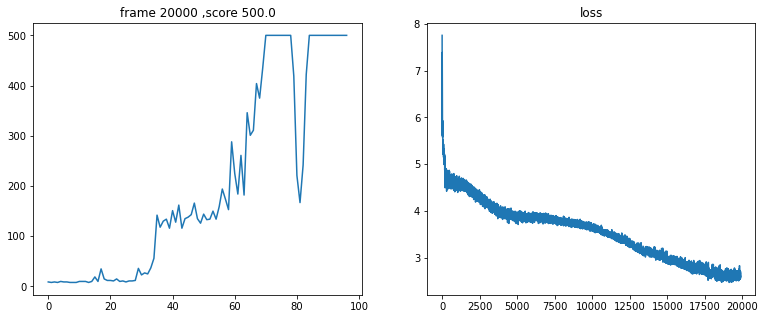

In [11]:
agent.train(num_frames=num_frames) # 训练模型并输出训练过程图像

## Test

In [12]:
i = 0
while i<10:
    video_folder="videos/Rainbow"
    agent.test(video_folder=video_folder)
    i += 1

D:\Anaconda3\envs\pytorch\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at C:\Users\20613\Desktop\14.Rainbow is all you need master\videos\Rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。
倒立摆一共维持500步。


## Render

In [13]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/Rainbow\rl-video-episode-0.mp4


## Calculate running average and plot

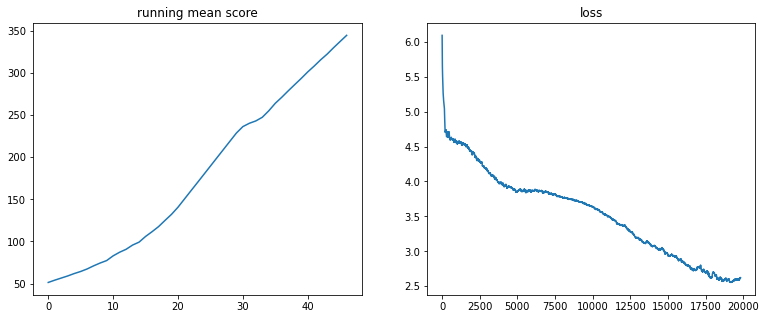

In [14]:
def running_mean(x,N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel@x[i:i+N]
        y[i]/=N
    return y

score = running_mean(np.array(agent.scores)) # 得到分数
loss = running_mean(np.array(agent.losses))  # 得到损失

clear_output(wait=True)
plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三张图像
plt.subplot(131)
plt.title("running mean score") 
plt.plot(score)
plt.subplot(132)
plt.title("loss")
plt.plot(loss)
plt.show() # 显示图像